## 相互情報量
単語carに対しては、明らかにdriveなどの単語が深く関係している。しかし、単純なカウントベースの共起行列ではtheのような頻出単語が深く関連してしまう。この問題点を解決するために、相互情報量PMI(Pointwise Mutual Information)という指標を導入する。PMIは次式て定義される

$$
PMI(x, y) = \log_{2}\frac{P(x, y)}{P(x)P(y)}
$$

$P(x)$はxがコーパスの中で出現した回数。$P(x,y)$は共起した回数、つまりそれぞれが近くで観測された回数。

コーパス中の単語数を$N$、共起行列を$C(x,y)$、コーパス中に出現する単語$x$の出現回数を$C(x)$とすると、

$$
PMI(x,y) = \log_{2}\frac{C(x, y)N}{C(x)C(y)}
$$

となる。

では、一度も共起しない単語同士のPMIはどうなるかと言うと、負の無限大へ発散してしまう。そのため、実際には正の相互情報量PPMI(Positive PMI)を用いる

$$
PPMI(x, y) = \max(0, PMI(x, y))
$$

In [12]:
import numpy as np

# verboseは進捗を表示するかどうか
def ppmi(C, verbose=False, eps=1e-8):
    M = np.zeros_like(C,dtype=np.float32)
    N = np.sum(C)
    S = np.sum(C, axis=0)
    total = C.shape[0] * C.shape[1]
    cnt = 0
    
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            pmi = np.log2(C[i, j] * N / (S[j] * S[i]) + eps)
            M[i, j] = max(0, pmi)
            
            if verbose:
                cnt += 1
                if cnt % (total//100) == 0:
                    print('%.1f%% done' % (100*cnt/total))
    
    return M

In [13]:
import sys
sys.path.append("../../deep-learning-from-scratch-2")

In [14]:
from common.util import preprocess, create_co_matrix, cos_similarity

In [66]:
text = "you say goodbye and i say hello. becouse i feel sad and happy."
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

In [67]:
np.set_printoptions(precision=3)
print("covariance matrix")
print(C)
print("-"*50)
print("PPMI")
print(W)

covariance matrix
[[0 1 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 1 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 1 1]
 [0 1 0 1 0 0 0 1 1 0 0]
 [0 1 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 1]
 [0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 1 0 0 0 0]]
--------------------------------------------------
PPMI
[[ 0.     2.807  0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 2.807  0.     1.807  0.     0.807  1.807  0.     0.     0.     0.     0.   ]
 [ 0.     1.807  0.     1.807  0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     1.807  0.     0.807  0.     0.     0.     0.     1.807
   1.807]
 [ 0.     0.807  0.     0.807  0.     0.     0.     1.807  1.807  0.     0.   ]
 [ 0.     1.807  0.     0.     0.     0.     2.222  0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     2.222  0.     2.222  0.     0.     2.222]
 [ 0.     0.     0.     0.     1.807  0.     2.222  0.     0.     0.     0.   ]
 [ 0.   

## 次元削減
単純な共起行列に単語自体の出現回数を加味した指数pmiを導入し、よりより行列を手に入れた。

しかし、このままでは単語が増えるにつれて次元がどんどん大きくなっていく。そこで次に次元を削減していく。

例えば、PPMIの行列には0が多く、無駄なデータ(疎なベクトル)が多い。そこで、新たに座標軸を導入し、少ない次元で元のデータをよく表現できるようにする。具体的には、特異値分解(singular Value Decomposition: SVD)を使う。SVDは任意の行列を次のように４つの行列の席へと分解する

$$
X = USV^{T}
$$

$U,V$は直交行列、$S$は対角行列

$U$は直交行列であるから、その列ベクトルは互いに直交する。すなわち、何らかの直交基底になっている。そこで、この$U$を単語空間として扱う。また、$S$は対角行列であり、特異値が大きい順に並んでいる。今の文脈では、対応する軸の重要度と考えることも出来る。

そこで、アイデアとしてはPPMI行列を$X$とし、SVDを行い、対角行列$S$からいくつかの特異値を選び、次元を削減する。特異値を選択すると、対応する直交行列$U$から軸を選択することになる。

実装上はlinalgモジュールにsvdというメソッドが用意されてるのでそれを使う

In [68]:
U, S, V = np.linalg.svd(W)

In [92]:
np.dot(U, np.dot(np.diag(S), V))

array([[  1.164e-08,   2.807e+00,  -9.313e-09,   6.519e-09,  -4.284e-08,
          1.676e-08,  -8.103e-08,  -4.284e-08,  -2.701e-08,   4.284e-08,
         -5.355e-09],
       [  2.807e+00,  -2.311e-08,   1.807e+00,  -2.468e-08,   8.074e-01,
          1.807e+00,  -8.778e-08,  -8.661e-08,  -1.863e-09,  -3.679e-08,
         -8.621e-08],
       [ -5.588e-09,   1.807e+00,   6.706e-08,   1.807e+00,  -1.490e-08,
          2.980e-08,  -7.451e-08,  -4.470e-08,  -6.706e-08,   5.960e-08,
          2.328e-08],
       [  1.397e-08,  -1.146e-07,   1.807e+00,   3.353e-08,   8.074e-01,
          2.980e-08,  -1.490e-08,  -3.725e-08,   1.118e-08,   1.807e+00,
          1.807e+00],
       [ -5.029e-08,   8.074e-01,   1.490e-08,   8.074e-01,  -7.451e-08,
         -7.059e-33,  -5.960e-08,   1.807e+00,   1.807e+00,   8.941e-08,
         -6.333e-08],
       [  5.588e-09,   1.807e+00,   4.470e-08,   2.980e-08,  -5.960e-08,
         -5.626e-17,   2.222e+00,  -2.980e-08,   3.725e-08,  -1.490e-08,
          1.67

In [93]:
import matplotlib.pyplot as plt

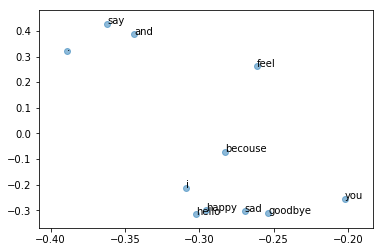

In [95]:
for word, word_id in word_to_id.items():
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1],alpha=0.5)
plt.show()    